In [ ]:
#此代码画最佳的多元回归图

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
from keras.models import Sequential
from sklearn import metrics
from scipy.io import loadmat
from sklearn.linear_model import LinearRegression
from keras.layers import LSTM, Dense, Dropout, SimpleRNN
import matplotlib.pyplot as plt
import matplotlib
import os
import xlsxwriter
from scipy import stats
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.size'] = 15
plt.rcParams['axes.unicode_minus'] = False
plt.subplots_adjust(wspace=0, hspace=150)
plt.tight_layout()

running_num = 1000
fig_rows = 1
fig_cols = 1
training_proportion_range = [0.7]
testing_pro = 0.3
data_num = 22#25
test_num = data_num * testing_pro
cov = [0 for tt in range(data_num)]
my_test_pred = [ [] for tt in range(data_num)]

factors2 = ('chla','DIN','WS')
factors1 = ('chla','DIN','WS','Current','temp')
factors3 = ('chla','DIN','WS','DIN_SD','chla_SD')
factors_all = ('chla', 'temp', 'DIN', 'density', 'chla_SD', 'std_temp_SD', 'DIN_SD', 'density_SD', 'WS', 'Current')
factors_best = ('chla_SD', 'std_temp_SD', 'DIN_SD', 'density_SD', 'WS')

<Figure size 432x288 with 0 Axes>

In [2]:
#这里的real和pred都是np.array格式，默认传入的real和pred的size一样
#算NSE
def cal_NSE(real, pred, mean):
    numerator=0
    denominator=0
    for it in range(len(real)):
        numerator += (pred[it]-real[it]) ** 2
        denominator += (real[it]-mean) ** 2
    nse = 1 - numerator/denominator
    return nse

#算RMSE
def cal_RMSE(real, pred):
    n = len(pred)
    numerator = 0
    for it in range(len(pred)):
        numerator += (pred[it] - real[it]) * (pred[it] - real[it])
    RMSE = (numerator/n) ** 0.5
    return RMSE

#算Pcorr,mean是所有数据的mean还是test的mean
def cal_Pcorr(real, pred, mean):
    pred_mean = pred.mean(axis=0)
    numerator=0
    denominator=0
    a = 0
    b = 0
    for it in range(len(pred)):
        numerator += (pred[it]-pred_mean)*(real[it]-mean)
        a += (pred[it]-pred_mean) ** 2
        b += (real[it]-mean) ** 2
    denominator = (a*b) ** 0.5
    Pcorr = numerator / denominator
    return Pcorr

def cal_Cov(pred, real):
    cov = 0
    #print(len(pred))
    for i in range(len(pred)):
        cov += pow((pred[i] - real),2)
    cov = cov / len(pred)
    return cov

In [3]:
#DataSet is the name of the DataSet
#Data contains P_val, NSE and RMSE
#workbook has been created in main function
def write_excel(workbook,sheet_name,total,nse_test_array, nse_train_array):    
    worksheet = workbook.add_worksheet(sheet_name) #create a sheet for DataSet
    worksheet.write(1,0,'test_data')
    worksheet.write(2,0,'train_data')
    worksheet.write(0,1,'nse_mean')
    worksheet.write(0,2,'nse_std')
    worksheet.write(0,3,'nse_min')
    worksheet.write(0,4,'nse_max')
    worksheet.write(1,1,nse_test_array[0])
    worksheet.write(1,2,nse_test_array[1])
    worksheet.write(1,3,nse_test_array[2])
    worksheet.write(1,4,nse_test_array[3])
    worksheet.write(2,1,nse_train_array[0])
    worksheet.write(2,2,nse_train_array[1])
    worksheet.write(2,3,nse_train_array[2])
    worksheet.write(2,4,nse_train_array[3])
    
    worksheet.write(4,0,'序号')
    worksheet.set_column('A:A',10)#设置第2列宽度为20像素
    #worksheet.write(3,1,'模型')
    worksheet.write(4,1,'Pcorr')
    worksheet.write(4,2,'NSE')
    worksheet.write(4,3,'RMSE')
    worksheet.write(4,4,'pvalue')
    for r in range(int(len(total))):
        worksheet.write(r+5,0,r)
        #worksheet.write(r+1,1,total[r]['factors_str'])
        worksheet.write(r+5,1,total[r]['pcorr'])
        worksheet.write(r+5,2,total[r]['nse'])
        worksheet.write(r+5,3,total[r]['rmse'])
        worksheet.write(r+5,4,total[r]['pvalue'])

In [4]:
#DataSet is the name of the DataSet
#Data contains P_val, NSE and RMSE
#workbook has been created in main function
def write_excel2(workbook,sheet_name,total,nse_test_array, nse_train_array,cov):    
    worksheet = workbook.add_worksheet(sheet_name) #create a sheet for DataSet
    worksheet.write(1,0,'test_data')
    worksheet.write(2,0,'train_data')
    worksheet.write(0,1,'nse_mean')
    worksheet.write(0,2,'nse_std')
    worksheet.write(0,3,'nse_min')
    worksheet.write(0,4,'nse_max')
    worksheet.write(1,1,nse_test_array[0])
    worksheet.write(1,2,nse_test_array[1])
    worksheet.write(1,3,nse_test_array[2])
    worksheet.write(1,4,nse_test_array[3])
    worksheet.write(2,1,nse_train_array[0])
    worksheet.write(2,2,nse_train_array[1])
    worksheet.write(2,3,nse_train_array[2])
    worksheet.write(2,4,nse_train_array[3])
    worksheet.write(0,6,'年份')
    worksheet.write(0,7,'Cov')
    for i in range(len(cov)):
        worksheet.write(i+1,6,cov['year_index'][i])
        worksheet.write(i+1,7,cov['cov'][i])
    worksheet.write(4,0,'序号')
    worksheet.set_column('A:A',10)#设置第2列宽度为20像素
    #worksheet.write(3,1,'模型')
    worksheet.write(4,1,'Pcorr')
    worksheet.write(4,2,'NSE')
    worksheet.write(4,3,'RMSE')
    worksheet.write(4,4,'pvalue')
    rmse_mean = 0
    for r in range(int(len(total))):
        worksheet.write(r+5,0,r)
        #worksheet.write(r+1,1,total[r]['factors_str'])
        worksheet.write(r+5,1,total[r]['pcorr'])
        worksheet.write(r+5,2,total[r]['nse'])
        worksheet.write(r+5,3,total[r]['rmse'])
        rmse_mean = rmse_mean + total[r]['rmse']
        worksheet.write(r+5,4,total[r]['pvalue'])
    rmse_mean = rmse_mean / len(total)
    return rmse_mean

In [5]:
# listing all file names: all .mat file in my computer are stored in ./data/ directory 
file_names = ['HI-04-16-17']
file_dir = 'C:/Users/admin/data1/'
dt = np.dtype([('factors_str',str,80), ('r_2_0', float), ('nse', float), ('rmse', float), \
    ('pcorr', float), ('test_y', np.ndarray), ('test_pred', np.ndarray),('train_pred', np.ndarray), ('pvalue',float), \
    ('window_size', int), ('training_proportion', float),('test_year',np.ndarray),('train_year',np.ndarray)])
year_cov = np.dtype([('year_index',list),('cov',list)])

selected_kinds:  ['chla', 'DIN', 'WS', 'Current', 'temp', 'year']
1000


<ipython-input-6-af2c9524b70f>:225: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  subfigures[kk].scatter(x, data['HI'], marker='o', edgecolor='r', s=70, linewidths=3, color='', label='HI实际数据点')


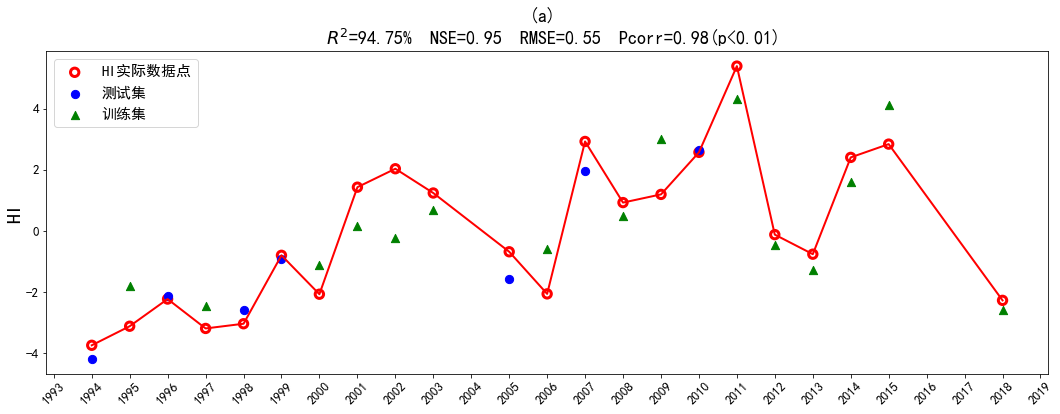

In [6]:
workbook = xlsxwriter.Workbook('HI_多元回归_04-16-17.xlsx') #create a excel table named result.xlsx
workbook2 = xlsxwriter.Workbook('HI_多元回归_04-16-17.xlsx') 
# reading data from .mat
performance = np.array([], dtype=year_cov)
for name in file_names:
    for training_proportion in training_proportion_range:
        if training_proportion == 1:
            running_num = 10
        for window_size in [1]:
            file_path = file_dir + name + '.mat'
            data = loadmat(file_path)['X']
            data = pd.DataFrame(data, columns=('chla', 'temp', 'DIN', 'density', 'chla_SD', 'std_temp_SD', 'DIN_SD', 'density_SD', 'WS', 'Current', 'HI', 'year'))
            
            data = data.reset_index(drop=True)    ###for monthly
            # converting data type
            data['year'] = data['year'].astype('i4')

            all_kinds = []
    
            all_kinds.append(list(factors1))
            all_kinds.append(list(factors2))
            Data = []
            
            for k in range(1):  
                fig, subfigure = plt.subplots(fig_rows, fig_cols, figsize=(15 * fig_cols, 6 * fig_rows))
                subfigures = []
                subfigures.append(subfigure)
                all_rmse = []
                all_test_rmse = []
                all_train_rmse = []
                all_test_nse = []
                all_train_nse = []
                nse_test_array = []
                nse_train_array = []
                total = np.array([], dtype=dt)
                selected_kinds = all_kinds[k]
                factors_str = ''
                #factors_str = 'factors: '
                for i in selected_kinds:
                    factors_str += i
                    factors_str += ' '
                
                Data.append(factors_str)
                selected_kinds.append('year')
                print("selected_kinds: ",selected_kinds)
                # constructing datasets
                X = data[selected_kinds]
                Y = data['HI']
                selected_kinds.remove('year')
                
                total_NSE = 0
                
                for i in range(running_num):
                    if training_proportion == 1:
                        all_train = all_test = X
                        Y_train = Y_test = Y
                    else:
                        all_train, all_test, Y_train, Y_test = train_test_split(X, Y, test_size=(1 - training_proportion), random_state=i)
                    X_train = all_train[selected_kinds]
                    X_test = all_test[selected_kinds]
                    
                    #data preprocessing: data standardization
                    X_mean = X_train.mean(axis=0)
                    X_std = X_train.std(axis=0)
                    Y_mean = Y_train.mean(axis=0)
                    Y_std = Y_train.std(axis=0)
                    X_train_norm = (X_train - X_mean) / X_std
                    Y_train_norm = (Y_train - Y_mean) / Y_std
                    X_test_norm = (X_test - X_mean) / X_std
                    Y_test_norm = (Y_test - Y_mean) / Y_std
            ##############################################################
                    # 多元线性回归
                    linreg = LinearRegression()
                    model = linreg.fit(X_train_norm, Y_train_norm)
                    
                    test_pred = model.predict(X_test_norm)
                    train_pred = model.predict(X_train_norm)
                    clf_test_pred = test_pred * Y_std + Y_mean
                    clf_train_pred = train_pred * Y_std + Y_mean
                    
                    #计算R2
                    R_2_0 = metrics.r2_score(Y_test.values, clf_test_pred) 
                    
                    #计算NSE, RMSE, Pcorr
                    NSE_test = cal_NSE(Y_test.values, clf_test_pred, Y_mean)
                    NSE_train = cal_NSE(Y_train.values, clf_train_pred, Y_mean)
                    RMSE = cal_RMSE(Y_test.values, clf_test_pred)
                    RMSE_test = cal_RMSE(Y_test.values, clf_test_pred)
                    RMSE_train = cal_RMSE(Y_train.values, clf_train_pred)
                    pearson = stats.pearsonr(np.array(Y_test, dtype='float'), np.array(clf_test_pred, dtype='float'))
                    Pcorr = pearson[0]
                    pvalue = pearson[1]
                
                    Data.append(Pcorr)
                    Data.append(NSE_test)
                    Data.append(RMSE)
                    all_rmse.append(RMSE)
                    all_test_nse.append(NSE_test)
                    all_train_nse.append(NSE_train)
                    all_test_rmse.append(RMSE_test)
                    all_train_rmse.append(RMSE_train)
                    test_year = all_test['year'][:]
                    train_year = all_train['year'][:]
                    
                    for mm in range(int(test_num)):
                        my_test_pred[test_year.index[mm]].append(clf_test_pred[mm]) 
                    
                    item = (factors_str, R_2_0, NSE_test, RMSE, Pcorr, Y, clf_test_pred, clf_train_pred, pvalue, window_size, training_proportion, test_year, train_year)
                    total = np.append(total, np.array(item, dtype=dt))
                
                for mm in range(data_num):
                    cov[mm] = cal_Cov(my_test_pred[mm],data['HI'][mm])
                    item2 = (mm+1994,cov[mm])
                    performance = np.append(performance,np.array(item2,dtype = year_cov))
                print(len(total))
                nse_test_mean = np.mean(all_test_nse)
                nse_test_std = np.std(all_test_nse, ddof=1)
                nse_test_sorted = sorted(all_test_nse)
                nse_test_max = nse_test_sorted[len(nse_test_sorted) - 1]
                nse_test_min = nse_test_sorted[0]
                nse_test_array.append(nse_test_mean)
                nse_test_array.append(nse_test_std)
                nse_test_array.append(nse_test_min)
                nse_test_array.append(nse_test_max)
                
                nse_train_mean = np.mean(all_train_nse)
                nse_train_std = np.std(all_train_nse, ddof=1)
                rmse_std = np.std(all_train_nse,ddof=1)
                rmse_train_mean = np.mean(all_train_rmse)
                rmse_test_mean = np.mean(all_test_rmse)
                rmse_train_std = np.std(all_train_rmse)
                rmse_test_std = np.std(all_test_rmse)
                nse_train_sorted = sorted(all_train_nse)
                nse_train_max = nse_train_sorted[len(nse_train_sorted) - 1]
                nse_train_min = nse_train_sorted[0]
                nse_train_array.append(nse_train_mean)
                nse_train_array.append(nse_train_std)
                nse_train_array.append(nse_train_min)
                nse_train_array.append(nse_train_max)
                
                total = sorted(total, key=lambda x: x['nse'])
                total = np.flipud(total)
                performance = np.sort(performance, kind = 'mergesort',order='cov')
                write_excel(workbook, factors_str, total, nse_test_array, nse_train_array)#write result into excel file
                rmse_mean = write_excel2(workbook2, factors_str, total, nse_test_array, nse_train_array,performance)
                for kk in range(1):
                    # 建立时间戳，作为图表下标
                    if kk == 0:
                        m = 0
                    else:
                        m = len(total) - 1
                    window_size = total[m]['window_size']
                    training_proportion = total[m]['training_proportion']
                    years = list(data['year'])

                    test_years = total[m]['test_year']
                    train_years = total[m]['train_year']
                    x = [str(year) for year in years]
                    x = [datetime.strptime(i, '%Y') for i in x]
                    x = matplotlib.dates.date2num(x)
                    test_x = [str(year) for year in test_years]
                    test_x = [datetime.strptime(i, '%Y') for i in test_x]
                    test_x = matplotlib.dates.date2num(test_x)
                    train_x = [str(year) for year in train_years]
                    train_x = [datetime.strptime(i, '%Y') for i in train_x]
                    train_x = matplotlib.dates.date2num(train_x)
                    # 实际值与预测值对比图
                    plt.subplots_adjust(wspace=0, hspace=0.4)
                    subfigures[kk].plot(x, data['HI'], 'r-', linewidth = 2, label='')
                    plt.ylabel("HI",size=20)
                    subfigures[kk].scatter(x, data['HI'], marker='o', edgecolor='r', s=70, linewidths=3, color='', label='HI实际数据点')
                    subfigures[kk].scatter(test_x, total[m]['test_pred'], s=68, label='测试集', color = 'b')
                    subfigures[kk].scatter(train_x, total[m]['train_pred'], s=68, label='训练集', color = 'g',marker='^')
                    subfigures[kk].set_xticklabels(labels=x, rotation=45, size = 15)
                    subfigures[kk].tick_params(labelsize=13)
                    subfigures[kk].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
                    subfigures[kk].xaxis.set_major_locator(matplotlib.dates.YearLocator())
                    subfigures[kk].legend(loc='best')
                    subfigures[kk].set_title('(a) \n $R^2$={3}%  NSE={0}  RMSE={1}  Pcorr={2}(p<0.01)'.format(\
             round(total[m]['nse'],2), round(total[m]['rmse'],2), round(total[m]['pcorr'],2), \
            round(total[m]['r_2_0']* 100, 2)),size=18)
                        
                    subfigures[kk].legend(loc='upper left')
                plt.tight_layout()
                plt.savefig('HI_多元回归_'+ '最佳预测' + '.pdf')
                plt.savefig('HI_多元回归_'+ '最佳预测' + '.png')
workbook.close() #close excel file
workbook2.close()

In [7]:
print("test nse mean: ")
print(nse_test_mean)
print("train nse mean: ")
print(nse_train_mean)

test nse mean: 
0.6076901933426289
train nse mean: 
0.8579100392790987


In [8]:
print(rmse_train_mean)
print(rmse_test_mean)
print(rmse_train_std)
print(rmse_test_std)

0.8908737275832428
1.458397293700977
0.10967764791745817
0.33502892676337204


In [9]:
print(rmse_std)
print(nse_train_std)
print(nse_test_std)

0.04481730310226206
0.04481730310226206
0.26891823107425034
